In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
naneet1_hmmmmmm_path = kagglehub.dataset_download('naneet1/hmmmmmm')

print('Data source import complete.')

Data source import complete.


In [2]:
!pip install jiwer
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nv

In [3]:
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.amp import autocast, GradScaler
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import T5ForConditionalGeneration, T5Config, VivitConfig, VivitModel

# from tqdm.notebook import tqdm
from tqdm import tqdm
from PIL import Image
import json
import os
import numpy as np
import cv2
import random
from jiwer import wer
from ultralytics import YOLO
import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# import torch.multiprocessing as mp
# mp.set_start_method('fork', force=True)

2025-06-13 16:45:38.927230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749833139.377245      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749833139.491452      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
def show_sequence(sequence, NUM_FRAMES):
    columns = 4
    rows = (NUM_FRAMES + 1) // (columns)
    fig = plt.figure(figsize=(32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        frames = sequence[j].permute(1,2,0).numpy()
        frames = frames/ frames.max()
        plt.imshow(frames)

    plt.show()

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(42)

In [6]:
train_csv = "/kaggle/input/hmmmmmm/phoenix/annotations/manual/train.corpus.csv"
test_csv = "/kaggle/input/hmmmmmm/phoenix/annotations/manual/test.corpus.csv"
dev_csv = "/kaggle/input/hmmmmmm/phoenix/annotations/manual/dev.corpus.csv"

train_paths = "/kaggle/input/hmmmmmm/phoenix/fullFrame-210x260px/train"
test_paths = "/kaggle/input/hmmmmmm/phoenix/fullFrame-210x260px/test"
dev_paths =  "/kaggle/input/hmmmmmm/phoenix/fullFrame-210x260px/dev"

In [7]:
max_frames = 32
num_workers = 4
batch_size = 4
prefetch_factor = 4

In [8]:
word_to_idx = { '<p>':0, '<s>':1, '</s>':2}
idx_to_word = ['<p>', '<s>', '</s>']

arr_train = np.loadtxt(train_csv, delimiter='|', dtype='str')
arr_train = np.delete(arr_train,0,0)
arr_test = np.loadtxt(test_csv, delimiter='|', dtype='str')
arr_test = np.delete(arr_test,0,0)
arr_dev = np.loadtxt(dev_csv, delimiter='|', dtype='str')
arr_dev = np.delete(arr_dev,0,0)

arr = np.concatenate((arr_train, arr_test, arr_dev), axis=0)

for sentence in arr:
    for word in sentence[3].split(' '):
        if word not in idx_to_word:
            idx_to_word.append(word)
            word_to_idx[word] = len(idx_to_word)-1

In [9]:
len(idx_to_word), len(word_to_idx)

(1299, 1299)

In [10]:
class rwth_phoenix(Dataset):
    def __init__(self, csv, data_path, frame_transform, video_transform, input_fps, output_fps, max_frames, stride, word_dict):

        temp = np.loadtxt(csv, delimiter='|', dtype='str')
        self.csv = np.delete(temp, 0, 0)
        self.word_dict = word_dict
        self.data_path = data_path

        self.frame_transform = frame_transform
        self.video_transform = video_transform

        self.input_fps = input_fps
        self.output_fps = output_fps
        self.max_frames = max_frames
        self.stride = stride


    def __len__(self):
        return len(self.csv)


    def __getitem__(self, idx):
        folder = self.csv[idx][1].split('/')
        label = self.csv[idx][3].split(' ')

        words = []
        for word in label:
            words.append(self.word_dict[word])
        label = torch.tensor(words)
        image_folder_path = os.path.join(self.data_path, folder[0], folder[1])

        images = os.listdir(image_folder_path)
        end = len(images)

        step = self.input_fps/random.choice(self.output_fps)
        image_list = []
        if int(end//step +1) <= self.max_frames:
            frame_num, num = 0, 0
            while frame_num < end:
                num+=1
                if self.stride and num%self.stride == 0:
                    image_list.append(str(int(frame_num))+'a')

                else:
                    img = Image.open(os.path.join(image_folder_path, images[int(frame_num)]))
                    tensor_img = self.frame_transform(img)
                    image_list.append(tensor_img)
                frame_num += step

            c, h, w = image_list[-1].shape
            while len(image_list) < self.max_frames:
                image_list.append(torch.zeros(c,h,w))

            tensor_video = torch.stack(image_list[:self.max_frames])
            tensor_video = self.video_transform(tensor_video)

        else:
            frame_positions = np.linspace(0, end, self.max_frames, endpoint=False)
            num = 0
            for n in frame_positions:
                num+=1
                if self.stride and num%self.stride == 0:
                    image_list.append(str(int(n))+'a')

                else:
                    img = Image.open(os.path.join(image_folder_path, images[int(n)]))
                    tensor_img = self.frame_transform(img)
                    image_list.append(tensor_img)

            tensor_video = torch.stack(image_list[:self.max_frames])
            tensor_video = self.video_transform(tensor_video)


        return tensor_video, label

In [11]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop((248,200)),
    transforms.Resize((224,224)),
    transforms.RandomRotation((-5,5))
])

video_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5)
])

In [12]:
image_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
])

video_test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0)
])

In [13]:
def collate_fn(batch):
    sos_token = 1
    eos_token = 2

    vid, labels = zip(*batch)
    vid = torch.stack(vid)

    sequence_lens = [len(label) for label in labels]
    max_len = max(sequence_lens) + 2

    # Pad labels with SOS and EOS tokens
    y_input = torch.full((len(labels), max_len), fill_value=0, dtype=torch.long)
    y_target = torch.full((len(labels), max_len), fill_value=0, dtype=torch.long)

    for i, label in enumerate(labels):
        y_input[i, 0] = sos_token
        y_input[i, 1:len(label) + 1] = label
        y_target[i, 0:len(label)] = label
        y_target[i, len(label)] = eos_token

    return vid, y_input, y_target

In [14]:
train_dataset = rwth_phoenix(csv=train_csv,
                       data_path=train_paths,
                        frame_transform=image_transform , video_transform=video_transform, input_fps=25, output_fps=list(range(4,10)), max_frames=max_frames, stride=0, word_dict=word_to_idx)

test_dataset = rwth_phoenix(csv=test_csv,
                       data_path=test_paths,
                        frame_transform=image_test_transform , video_transform=video_test_transform, input_fps=25, output_fps=list(range(4,10)), max_frames=max_frames, stride=0, word_dict=word_to_idx)

dev_dataset = rwth_phoenix(csv=dev_csv,
                       data_path=dev_paths,
                        frame_transform=image_test_transform , video_transform=video_test_transform, input_fps=25, output_fps=list(range(4,10)), max_frames=max_frames, stride=0, word_dict=word_to_idx)

In [15]:
train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn, prefetch_factor=prefetch_factor, num_workers=num_workers, pin_memory=True)
test_dataloader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, collate_fn=collate_fn, prefetch_factor=prefetch_factor, num_workers=num_workers, pin_memory=True)
dev_dataloader = DataLoader(dataset=dev_dataset, shuffle=False, batch_size=batch_size, collate_fn=collate_fn, prefetch_factor=prefetch_factor, num_workers=num_workers, pin_memory=True)

In [16]:
vid, y_input, y_target = next(iter(train_dataloader))

In [17]:
vid.shape

torch.Size([4, 32, 3, 224, 224])

/tmp/ipykernel_35/2729402105.py:10: RuntimeWarning: invalid value encountered in divide
  frames = frames/ frames.max()
/usr/local/lib/python3.11/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


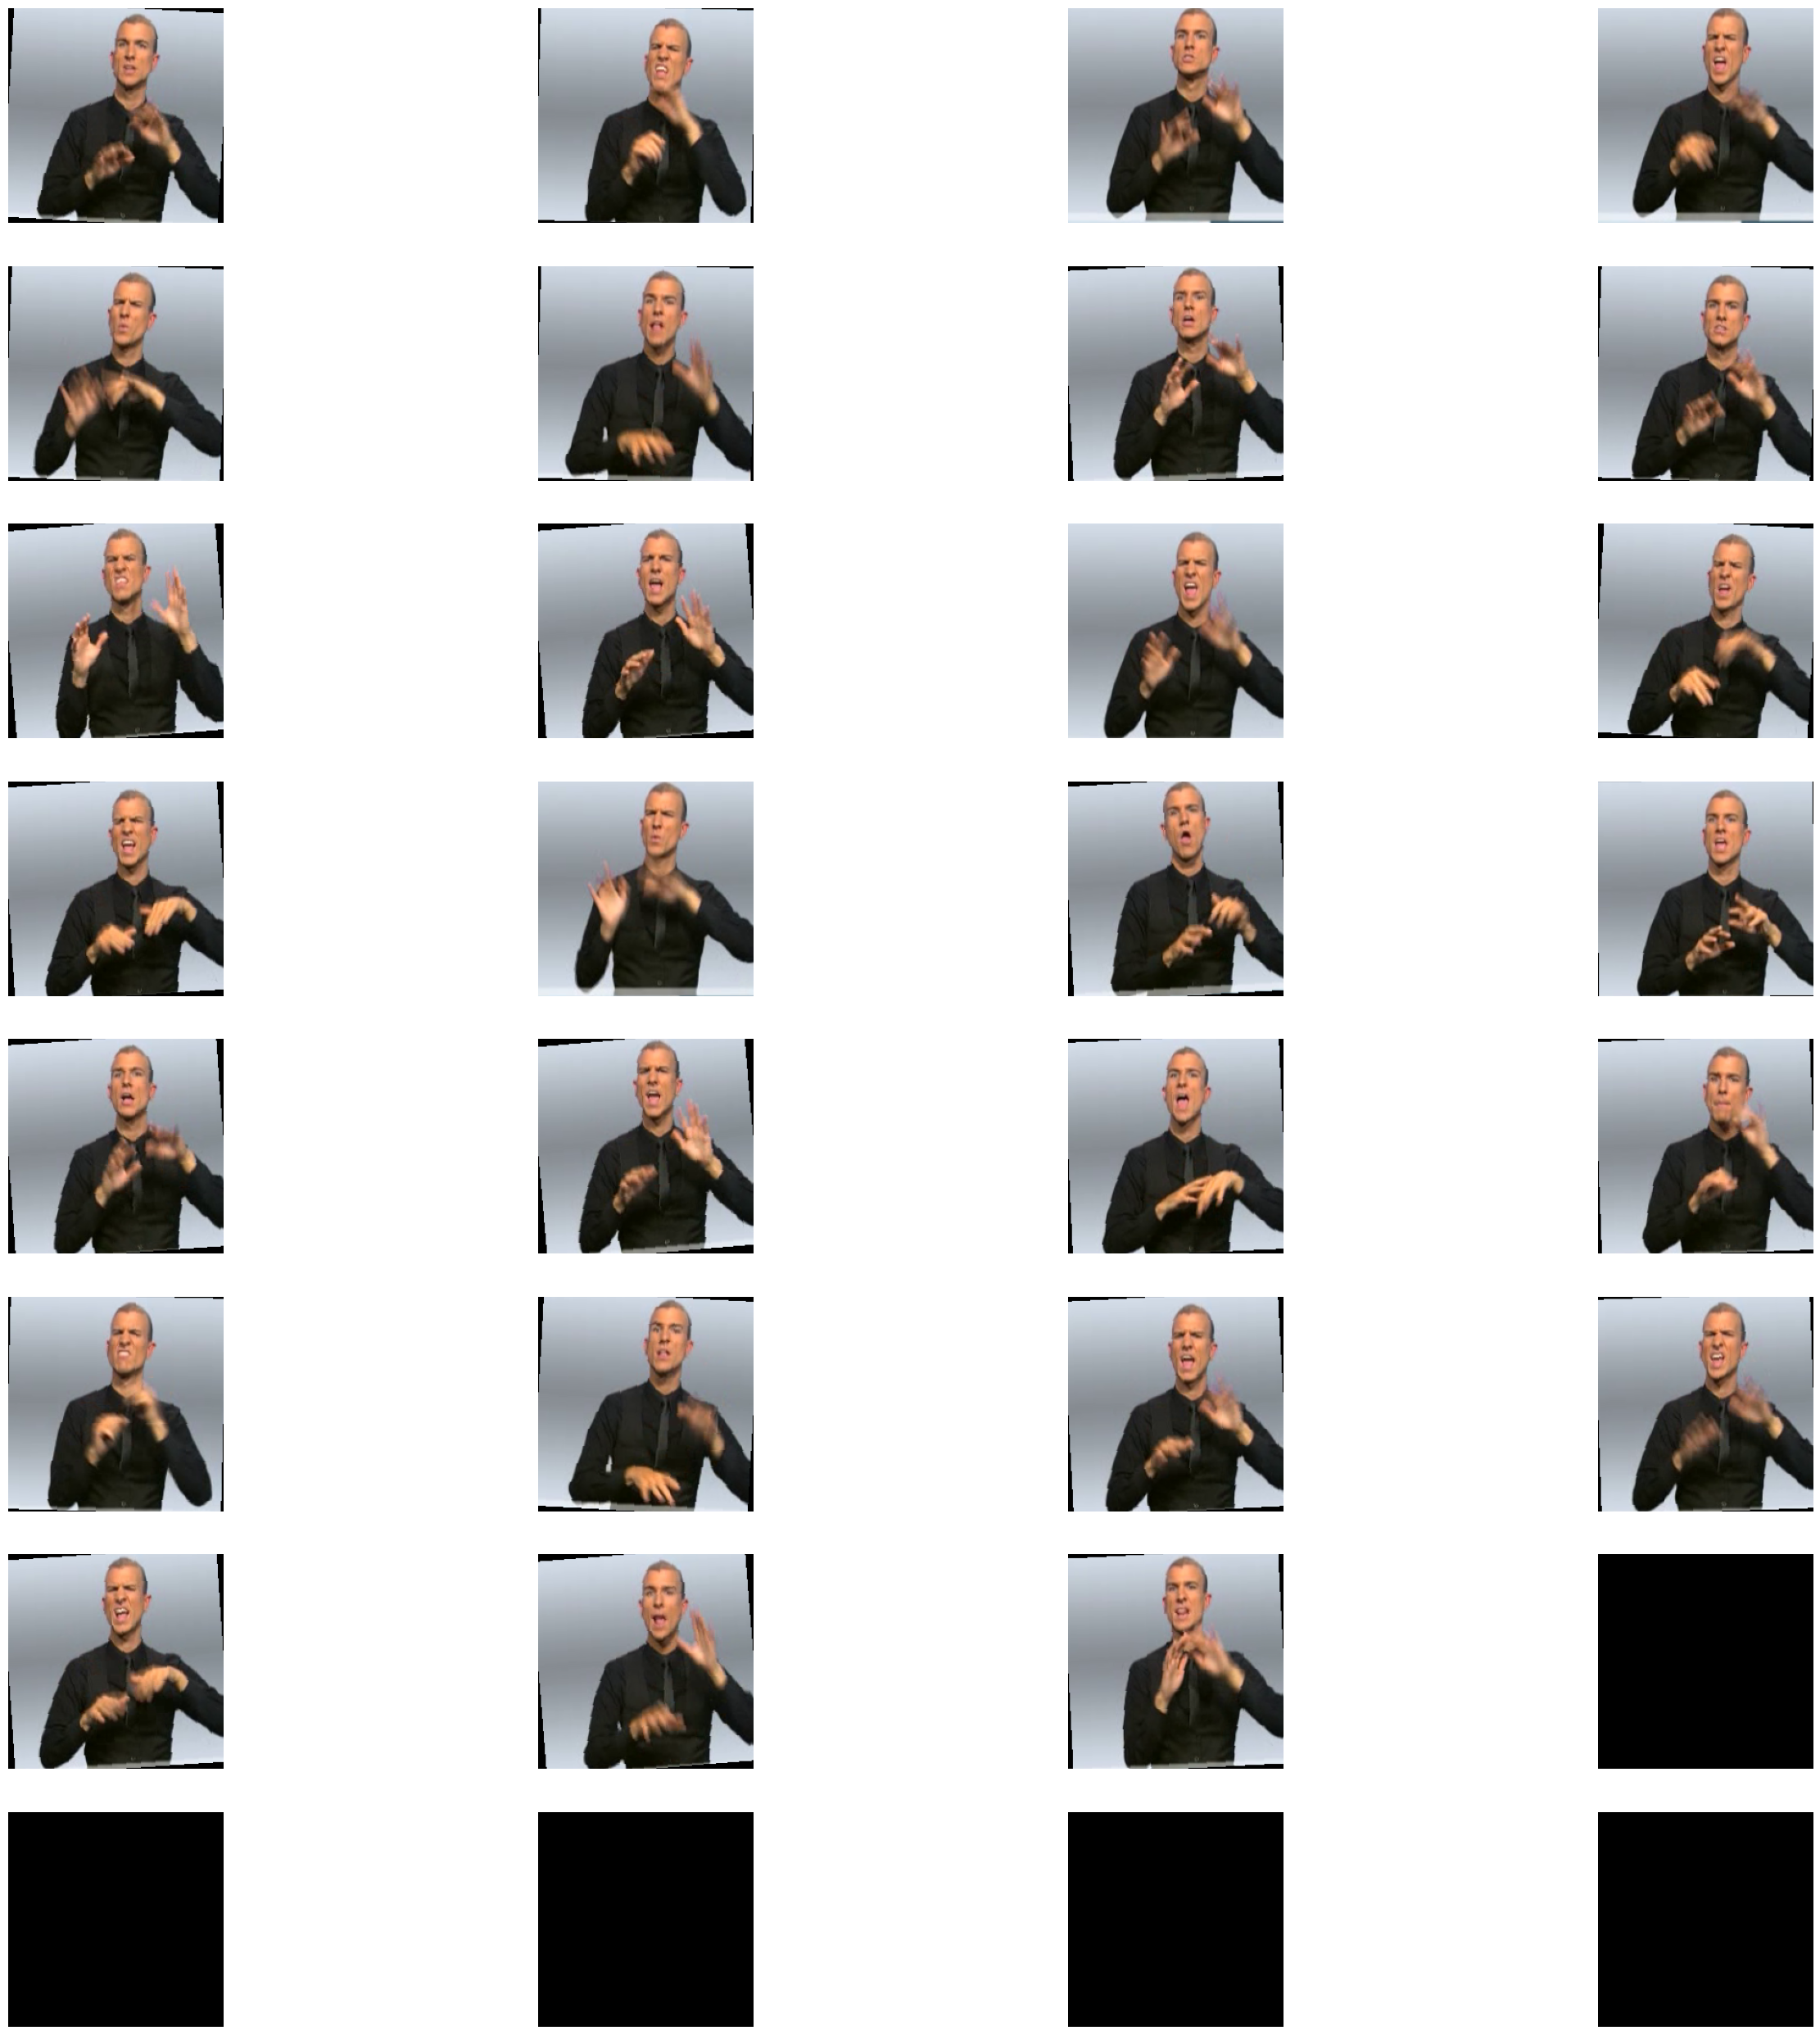

In [18]:
show_sequence(vid[2], 32)

In [19]:
def plot_img(images, keypoints):
    # keypoints = keypoints[0]
    tensor_images = []
    for n, image in enumerate(images):
        if type(image) != np.ndarray:
            image = np.asarray(image).copy()
            image *= (255.0/image.max())
            image = image.astype('uint8')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        color = (0,0,255)
        height, breadth, _ = image.shape
        for kps in keypoints[n].keypoints.xyn[0]:
            if kps[0] != 0 and kps[1] != 0:
                cv2.circle(image, (int(kps[0]*height), int(kps[1]*breadth)), radius=3, color=color, thickness=-1)
        tensor_images.append(torchvision.transforms.ToTensor()(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
    return torch.stack(tensor_images)

In [20]:
pose_model = YOLO("yolo11n-pose.pt").to("cuda")

100%|██████████| 5.97M/5.97M [00:00<00:00, 79.6MB/s]


In [21]:
import time
ct = time.time()

for X, y_input, y_target in tqdm(train_dataloader, 'Training'):
    X_list = []
    with torch.inference_mode():
        for n in range(X.shape[0]):
            pose_results = pose_model(X[n], verbose=False)
            X_list.append(plot_img(X[n].permute(0,2,3,1), pose_results))

    X = torch.stack(X_list)
    break
print(time.time()-ct)

Training:   0%|          | 0/1418 [00:00<?, ?it/s]/tmp/ipykernel_35/634333020.py:7: RuntimeWarning: divide by zero encountered in divide
  image *= (255.0/image.max())
/tmp/ipykernel_35/634333020.py:7: RuntimeWarning: invalid value encountered in multiply
  image *= (255.0/image.max())
/tmp/ipykernel_35/634333020.py:8: RuntimeWarning: invalid value encountered in cast
  image = image.astype('uint8')
Training:   0%|          | 0/1418 [00:07<?, ?it/s]

7.32494592666626


/tmp/ipykernel_35/2729402105.py:10: RuntimeWarning: invalid value encountered in divide
  frames = frames/ frames.max()
/usr/local/lib/python3.11/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


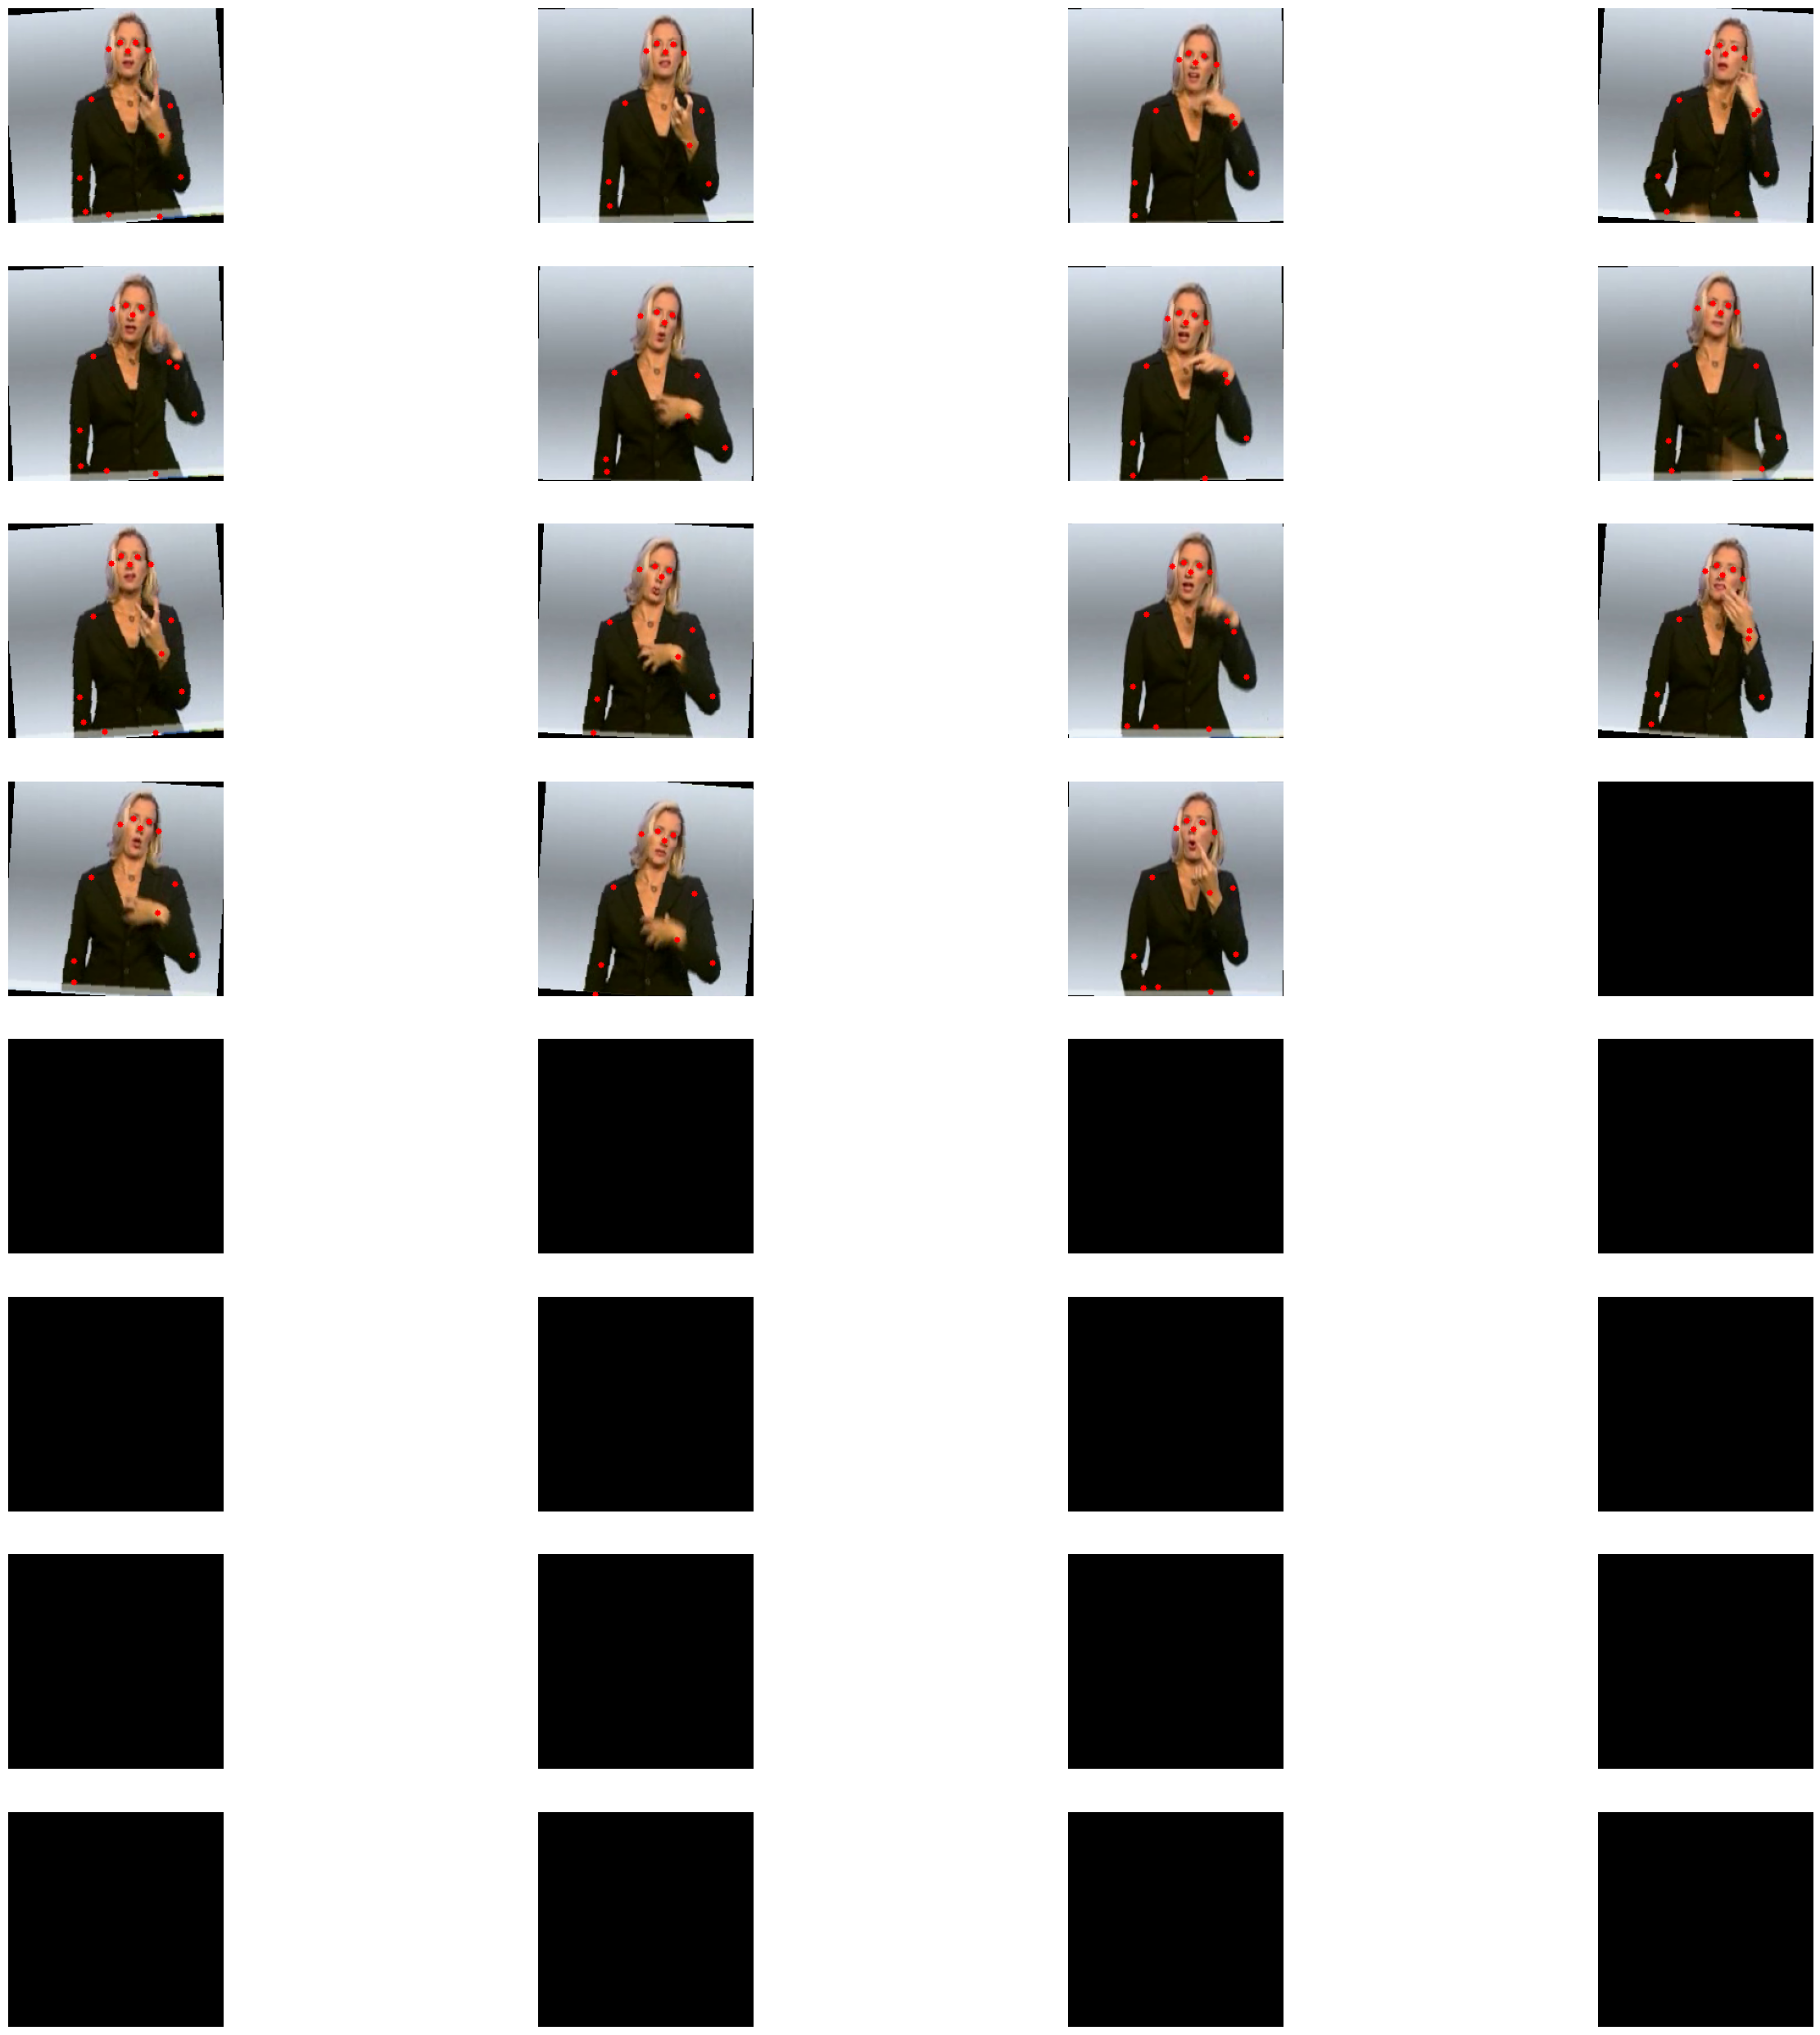

In [22]:
show_sequence(X[1], 32)

In [23]:
scaler = GradScaler('cuda')

def decode_token(tensor, idx_to_word=idx_to_word):
    n = tensor.shape[0]
    text = []
    for i in range(n):
        st = ''
        for token in tensor[i]:
            if token == 2:
                break
            elif token != 1 and token != 0:
                st += idx_to_word[token.item()]
        text.append(st)
    return text

def train_step(model, optimizer, dataloader, loss_fn, epoch, device="cuda"):
    model.train()
    train_loss, total_correct_wer = 0, 0

    for X, y_input, y_target in tqdm(dataloader, 'Training'):
        X_list = []
        with torch.inference_mode():
            for n in range(X.shape[0]):
                pose_results = pose_model(X[n], verbose=False)
                X_list.append(plot_img(X[n].permute(0,2,3,1), pose_results))

        X = torch.stack(X_list)

        X, y_input, y_target = X.to(device), y_input.to(device), y_target.to(device)

        with autocast('cuda'):
            y_logit = model(X, y_input)

            if y_logit.isnan().any():
                print("ABORT!!!! \nNan found in y_logit!")

            loss = loss_fn(y_logit.permute(0,2,1), y_target)
            train_loss += loss.item()

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        y_pred = torch.argmax(y_logit, dim=2)
        total_correct_wer += wer(decode_token(y_target), decode_token(y_pred))
        del X, y_input, y_target, y_logit, loss, y_pred

    acc_wer = (total_correct_wer / len(dataloader)) * 100
    avg_loss = train_loss / len(dataloader)

    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train WER: {acc_wer:.2f}%")


def test_step(model, loss_fn, epoch, dataloader, scheduler, device="cuda"):
    model.eval()
    test_loss, total_correct_wer = 0, 0

    for X, y_input, y_target in tqdm(dataloader, 'Testing'):
        X_list = []
        with torch.inference_mode():
            for n in range(X.shape[0]):
                pose_results = pose_model(X[n], verbose=False)
                X_list.append(plot_img(X[n].permute(0,2,3,1), pose_results))

        X = torch.stack(X_list)

        X, y_input, y_target = X.to(device), y_input.to(device), y_target.to(device)

        with autocast('cuda'):
            y_logit = model(X, y_input)

            if y_logit.isnan().any():
                print("ABORT!!!! \nNan found in y_logit!")

            loss = loss_fn(y_logit.permute(0,2,1), y_target)
            test_loss += loss.item()

        y_pred = torch.argmax(y_logit, dim=2)
        total_correct_wer += wer(decode_token(y_target), decode_token(y_pred))
        del X, y_input, y_target, y_logit, loss, y_pred

    acc_wer = (total_correct_wer / len(dataloader)) * 100
    avg_loss = test_loss / len(dataloader)

    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(avg_loss)

    print(f"Epoch {epoch} | Test Loss: {avg_loss:.4f} | Test WER: {acc_wer:.2f}%")

In [24]:
class ViViT_SLR(nn.Module):
    def __init__(self,
                 vivit_weights = "google/vivit-b-16x2-kinetics400",
                 t5_weights = "google-t5/t5-base",
                 vocab_size = 1299,
                 pad_token=0,
                 sos_token=1,
                 eos_token=2,
                 max_pred=512):

        super(ViViT_SLR, self).__init__()

        self.vivit_weights = vivit_weights
        self.t5_weights = t5_weights
        self.vivit = VivitModel.from_pretrained(self.vivit_weights, attn_implementation="sdpa", torch_dtype=torch.float32)

        self.normalize = nn.LayerNorm(768)

        self.t5 = self.copy_pretrained_T5_weights()

        self.pad_token = pad_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.vocab_size = vocab_size

        self.max_pred = max_pred

        self.fc_out = nn.Linear(768, vocab_size)

        self.init_weights()


    def forward(self, img, y_tokens):


        encoded_output = self.vivit(img).last_hidden_state
        encoded_output = self.normalize(encoded_output)

        # print("Encoded Output 1 (ViViT)")
        # print("Min:", encoded_output1.min().item())
        # print("Max:", encoded_output1.max().item())
        # print("Mean:", encoded_output1.mean().item())
        # print("Std Dev:", encoded_output1.std().item())
        # print("-" * 30)

        # print("Encoded Output 2 (r3d_18)")
        # print("Min:", encoded_output2.min().item())
        # print("Max:", encoded_output2.max().item())
        # print("Mean:", encoded_output2.mean().item())
        # print("Std Dev:", encoded_output2.std().item())
        # print("-" * 30)

        # print("Cross Attention Output")
        # print("Min:", attn_output.min().item())
        # print("Max:", attn_output.max().item())
        # print("Mean:", attn_output.mean().item())
        # print("Std Dev:", attn_output.std().item())
        # print("-" * 30)

        decoder_attention_mask = (y_tokens != self.pad_token).long()
        decoded_output = self.t5.decoder(input_ids=y_tokens, encoder_hidden_states=encoded_output, attention_mask=decoder_attention_mask).last_hidden_state
        logit = self.fc_out(decoded_output)

        return logit

    def init_weights(self):

        # Output Linear
        nn.init.xavier_uniform_(self.fc_out.weight)
        if self.fc_out.bias is not None:
            nn.init.constant_(self.fc_out.bias, 0)

    def copy_pretrained_T5_weights(self):

        config = T5Config.from_pretrained(self.t5_weights)
        config.vocab_size = 1299
        config.decoder_start_token_id = 1
        new_model = T5ForConditionalGeneration(config)
        pretrained_model = T5ForConditionalGeneration.from_pretrained(self.t5_weights)

        pretrained_dict = pretrained_model.state_dict()
        new_dict = new_model.state_dict()

        # Copy only weights that match shape and exclude embeddings & lm_head
        filtered_dict = {}
        for k, v in pretrained_dict.items():
            if (
                k in new_dict
                and not k.startswith("shared")
                and "embed_tokens" not in k
                and "lm_head" not in k
                and new_dict[k].shape == v.shape  # ensure shape matches
            ):
                filtered_dict[k] = v

        print(f"Copying {len(filtered_dict)} weights from pretrained T5 model.")
        new_dict.update(filtered_dict)
        new_model.load_state_dict(new_dict)
        return new_model

In [25]:
lr = 1e-4
dropout = 0.1

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = "cuda"

model = ViViT_SLR().to(device)
model = nn.DataParallel(model)
# checkpoint = torch.load(f="/kaggle/input/vvocr_final/pytorch/default/1/VVOCR.pth")
# new_state_dict = checkpoint["model_state_dict"]
# model.load_state_dict(new_state_dict, strict=True)
# model = nn.DataParallel(model)
# checkpoint = torch.load(f="/kaggle/input/vvocr/pytorch/default/1/VVOCR.pth")
# from collections import OrderedDict

# new_state_dict = OrderedDict()
# for k, v in checkpoint['model_state_dict'].items():
#     new_key = k.replace("module.", "")  # strip 'module.' prefix
#     new_state_dict[new_key] = v
# model.load_state_dict(new_state_dict, strict=True)

loss_fn = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
)

config.json:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/356M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Copying 256 weights from pretrained T5 model.


In [27]:
epochs = 100
torch.manual_seed(42)
torch.cuda.manual_seed(42)
for epoch in range(1,epochs):
  train_step(model=model,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epoch=epoch,
             dataloader=train_dataloader)
  test_step(model=model,
            loss_fn=loss_fn,
            epoch=epoch,
            dataloader=test_dataloader,
            scheduler=scheduler)

Training:   0%|          | 0/1418 [00:00<?, ?it/s]/tmp/ipykernel_35/634333020.py:7: RuntimeWarning: divide by zero encountered in divide
  image *= (255.0/image.max())
/tmp/ipykernel_35/634333020.py:7: RuntimeWarning: invalid value encountered in multiply
  image *= (255.0/image.max())
/tmp/ipykernel_35/634333020.py:8: RuntimeWarning: invalid value encountered in cast
  image = image.astype('uint8')
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Training: 100%|██████████| 1418/1418 [41:44<00:00,  1.77s/it]


Epoch 1 | Train Loss: 5.5072 | Train WER: 100.00%


Testing: 100%|██████████| 158/158 [02:42<00:00,  1.03s/it]


Epoch 1 | Test Loss: 5.2126 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [40:36<00:00,  1.72s/it]


Epoch 2 | Train Loss: 5.0819 | Train WER: 100.00%


Testing: 100%|██████████| 158/158 [02:37<00:00,  1.00it/s]


Epoch 2 | Test Loss: 5.0640 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [41:21<00:00,  1.75s/it]


Epoch 3 | Train Loss: 4.9409 | Train WER: 100.00%


Testing: 100%|██████████| 158/158 [02:42<00:00,  1.03s/it]


Epoch 3 | Test Loss: 4.9507 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [41:35<00:00,  1.76s/it]


Epoch 4 | Train Loss: 4.7683 | Train WER: 100.00%


Testing: 100%|██████████| 158/158 [02:39<00:00,  1.01s/it]


Epoch 4 | Test Loss: 4.8381 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [41:12<00:00,  1.74s/it]


Epoch 5 | Train Loss: 4.6435 | Train WER: 100.00%


Testing: 100%|██████████| 158/158 [02:38<00:00,  1.00s/it]


Epoch 5 | Test Loss: 4.7699 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [41:44<00:00,  1.77s/it]


Epoch 6 | Train Loss: 4.5451 | Train WER: 100.00%


Testing: 100%|██████████| 158/158 [02:42<00:00,  1.03s/it]


Epoch 6 | Test Loss: 4.7229 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [42:23<00:00,  1.79s/it]


Epoch 7 | Train Loss: 4.4829 | Train WER: 100.00%


Testing: 100%|██████████| 158/158 [02:44<00:00,  1.04s/it]


Epoch 7 | Test Loss: 4.7097 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [42:25<00:00,  1.80s/it]


Epoch 8 | Train Loss: 4.4559 | Train WER: 100.00%


Testing: 100%|██████████| 158/158 [02:51<00:00,  1.09s/it]


Epoch 8 | Test Loss: 4.6785 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [43:12<00:00,  1.83s/it]


Epoch 9 | Train Loss: 4.3858 | Train WER: 99.98%


Testing: 100%|██████████| 158/158 [02:51<00:00,  1.09s/it]


Epoch 9 | Test Loss: 4.6102 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [43:22<00:00,  1.84s/it]


Epoch 10 | Train Loss: 4.3257 | Train WER: 99.98%


Testing: 100%|██████████| 158/158 [02:49<00:00,  1.07s/it]


Epoch 10 | Test Loss: 4.6525 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [42:10<00:00,  1.78s/it]


Epoch 11 | Train Loss: 4.2815 | Train WER: 99.96%


Testing: 100%|██████████| 158/158 [02:41<00:00,  1.02s/it]


Epoch 11 | Test Loss: 4.5699 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [42:29<00:00,  1.80s/it]


Epoch 12 | Train Loss: 4.2414 | Train WER: 99.95%


Testing: 100%|██████████| 158/158 [02:48<00:00,  1.07s/it]


Epoch 12 | Test Loss: 4.5881 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [42:32<00:00,  1.80s/it]


Epoch 13 | Train Loss: 4.2437 | Train WER: 99.96%


Testing: 100%|██████████| 158/158 [02:46<00:00,  1.05s/it]


Epoch 13 | Test Loss: 4.5431 | Test WER: 99.84%


Training: 100%|██████████| 1418/1418 [42:43<00:00,  1.81s/it]


Epoch 14 | Train Loss: 4.1376 | Train WER: 99.84%


Testing: 100%|██████████| 158/158 [02:44<00:00,  1.04s/it]


Epoch 14 | Test Loss: 4.5022 | Test WER: 100.00%


Training: 100%|██████████| 1418/1418 [42:14<00:00,  1.79s/it]


Epoch 15 | Train Loss: 4.0692 | Train WER: 99.93%


Testing: 100%|██████████| 158/158 [02:43<00:00,  1.03s/it]


Epoch 15 | Test Loss: 4.4818 | Test WER: 100.00%


Training:  99%|█████████▊| 1397/1418 [41:55<00:37,  1.80s/it]


KeyboardInterrupt: 

In [ ]:
from IPython.display import FileLink
FileLink('vivit_r3d_t5_epoch_16.pth')